N:B Transformer model tested and adapted from https://github.com/ctxj/Time-Series-Transformer-Pytorch

7  - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:
       
         PERFORMANCE TESTING DI UN TRASFORMER ADATTATO PER TIME SERIES SU OSSERVAZIONI (TS MENSILE) RELATIVE ALLE ATTIVAZIONI
         DI CONTRATTI DEL SETTORE DELLA RISTORAZIONE IN LOMBARDIA

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists
import requests
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

In [22]:
rist = pd.read_csv('Ristorazione.csv')

In [23]:
rist.index = rist['DATA']

In [24]:
rist.drop(columns = 'DATA', inplace = True)

In [25]:
rist

,N.ATTIVATI
DATA,
2010-01-31,2254
2010-02-28,2139
2010-03-31,1869
2010-04-30,1867
2010-05-31,2054
...,...
2021-08-31,2016
2021-09-30,2401
2021-10-31,2467


In [28]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

cl =  np.array(rist['N.ATTIVATI'])
logreturn = np.diff(np.log(cl)) # Transform  to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

In [29]:
logreturn

array([-5.23679855e-02, -1.34934902e-01, -1.07066391e-03,  9.54562469e-02,
       -2.45420025e-01,  1.13972979e-01,  9.52597015e-02,  1.51912654e-01,
       -1.25510124e-01,  3.24091242e-02, -8.12429797e-03,  1.69524086e-01,
       -2.12167156e-01, -1.81915072e-02,  1.54223526e-01, -5.52577121e-02,
       -1.08701992e-01,  3.10086268e-01, -1.83077129e-01, -7.28877157e-02,
        7.24340981e-02,  9.67939819e-02, -1.14647512e-01, -6.93228500e-02,
        3.56427389e-01,  1.51361679e-02, -1.95864540e-01,  1.52607012e-01,
        7.84783420e-02, -3.06983836e-01, -7.97067426e-02,  1.66344693e-01,
        1.87225656e-02, -3.94788110e-02,  1.36985989e-01, -6.17785945e-01,
        3.80274859e-01,  3.24007352e-02,  1.44805721e-01, -8.08848130e-02,
       -1.61362312e-02, -2.82198018e-02, -2.76803387e-02, -1.14506382e-01,
       -5.07743093e-04,  3.00424313e-01, -3.45083863e-01,  1.82055988e-01,
       -1.27793129e-01,  4.23411751e-01, -2.36638271e-02, -2.46603787e-01,
        1.81097963e-01,  

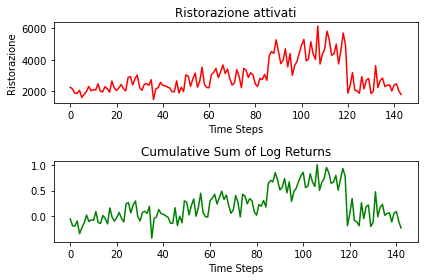

In [30]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(cl, color='red')
axs[0].set_title('Ristorazione attivati')
axs[0].set_ylabel('Ristorazione')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

POSITIONAL ENCODER


In [31]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

TRANSFORMER MODEL

In [32]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

WINDOW, SPLIT DATA INTO SEQUENCE WINDOW

In [33]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

SPLIT DATA IN TRAINING AND TESTING, PREPARED IN WINDOWED SEQUENCES AND PASS THROUGH GPU

In [34]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

SPLIT INTO TRAINING BATCHES

In [35]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

TRAINING FUNCTION

In [36]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if log_interval !=0 and batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

EVALUATING AFTER TRAINING

In [37]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

FUNCTION TO FORECAST 1 TIME STEP FROM WINDOW SEQUENCE

In [38]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

FORECAST ENTIRE SEQUENCE

In [39]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

DATA FOR TRAINING SPLIT

In [52]:
train_data, val_data = get_data(logreturn, 0.6) # 60% train, 40% test split
model = TransAm().to(device)

In [64]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  150 # Number of epochs

TRAINING LOOP

In [65]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step() 

--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.22s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   2 | time:  0.20s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   3 | time:  0.39s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   4 | time:  0.30s
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   5 | time:  0.21s
--------------------------------------------------------------------------------
--------------------

In [66]:
test_result, truth = forecast_seq(model, val_data)

0.1759796142578125 sec


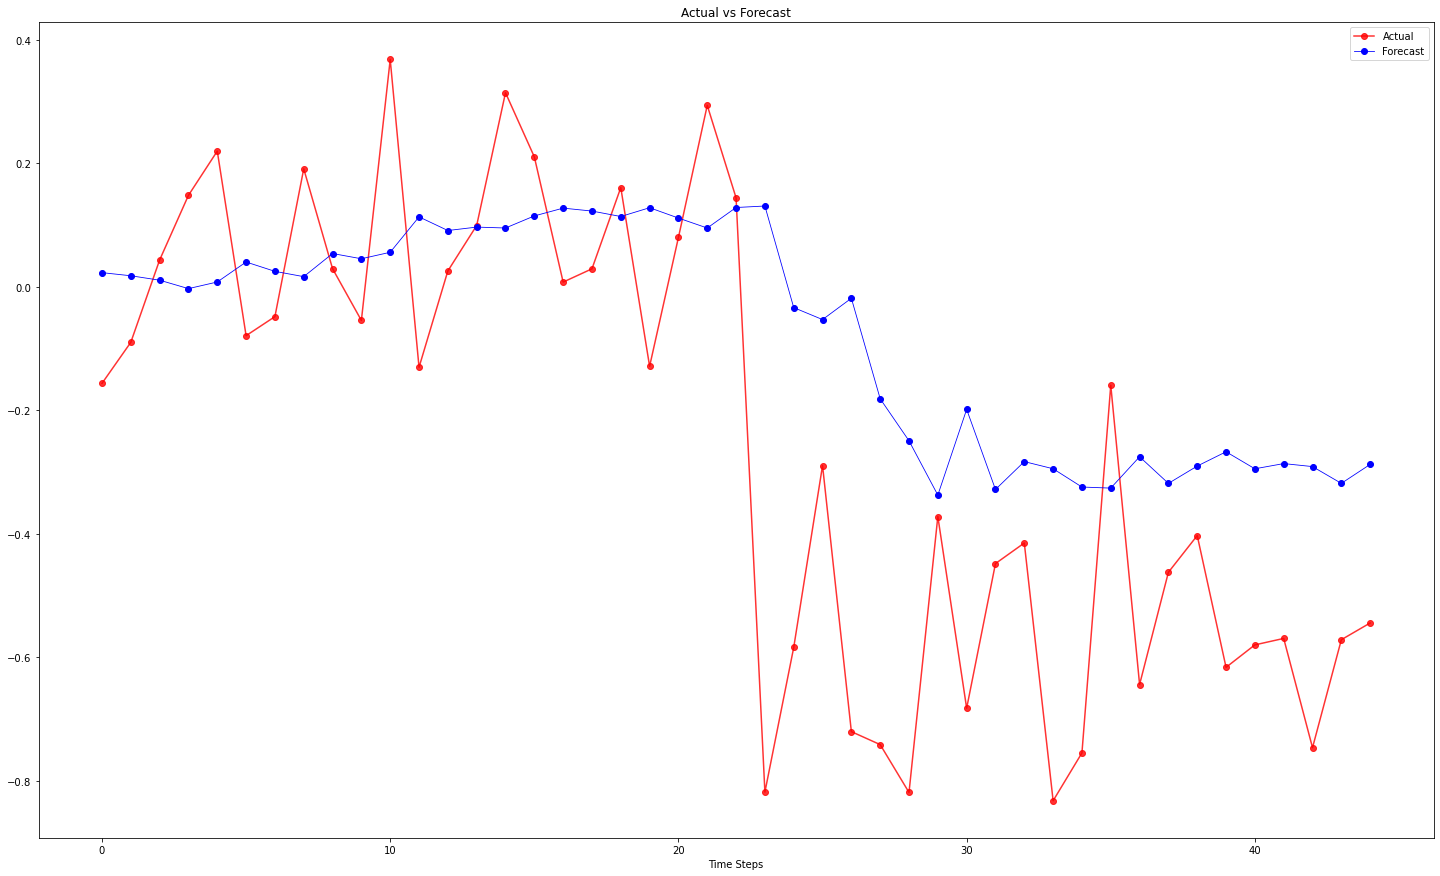

In [67]:
plt.figure(figsize=(25, 15))
kwsne = dict(marker='o')
plt.plot(truth, color='red', alpha=0.8, **kwsne)
plt.plot(test_result, color='blue', linewidth=0.8, **kwsne)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [68]:
test_result

tensor([ 0.0230,  0.0180,  0.0108, -0.0029,  0.0079,  0.0402,  0.0251,  0.0165,
         0.0540,  0.0455,  0.0560,  0.1133,  0.0912,  0.0968,  0.0953,  0.1148,
         0.1275,  0.1227,  0.1139,  0.1281,  0.1114,  0.0953,  0.1285,  0.1309,
        -0.0336, -0.0530, -0.0185, -0.1812, -0.2492, -0.3371, -0.1984, -0.3280,
        -0.2829, -0.2945, -0.3241, -0.3258, -0.2751, -0.3182, -0.2901, -0.2670,
        -0.2945, -0.2861, -0.2910, -0.3181, -0.2874])

In [69]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

MSE = mean_squared_error(truth, test_result)
RMSE = math.sqrt(MSE)
print('The mean square error is: ', MSE)
print('The Root Mean Square error is: ', RMSE)

The mean square error is:  0.099346995
The Root Mean Square error is:  0.3151935839348554


In [70]:
mape = mean_absolute_percentage_error(truth, test_result)
print(mape)

1.1893175
